Housingデータの読み込み

1978年に収集された住宅データ

- CRIME     犯罪発生率
- ZN        住宅区画の割合
- INDUS     非小売業の土地面積の割合
- CHAS      チャールズ川沿いかどうか
- NOX       窒素酸化物の濃度
- RM        1戸辺りの平均部屋数
- AGE       1940年より前の建物の割合
- DIS       主な雇用圏までの距離
- RAD       幹線道路へのアクセス指数
- TAX       所得税率
- PTRATIO   教師一人当たりの生徒の数
- B         アフリカ系居住者の割合
- LSTAT     低所得者の割合
- MEDV      住宅価格の中央値

In [14]:
import pandas as pd

df = pd.read_csv('../../data/housing/housing.data.txt', header=None, sep='\s+')

df.columns = ['CRIME', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df.head()

,CRIME,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


散布図行列を作成する

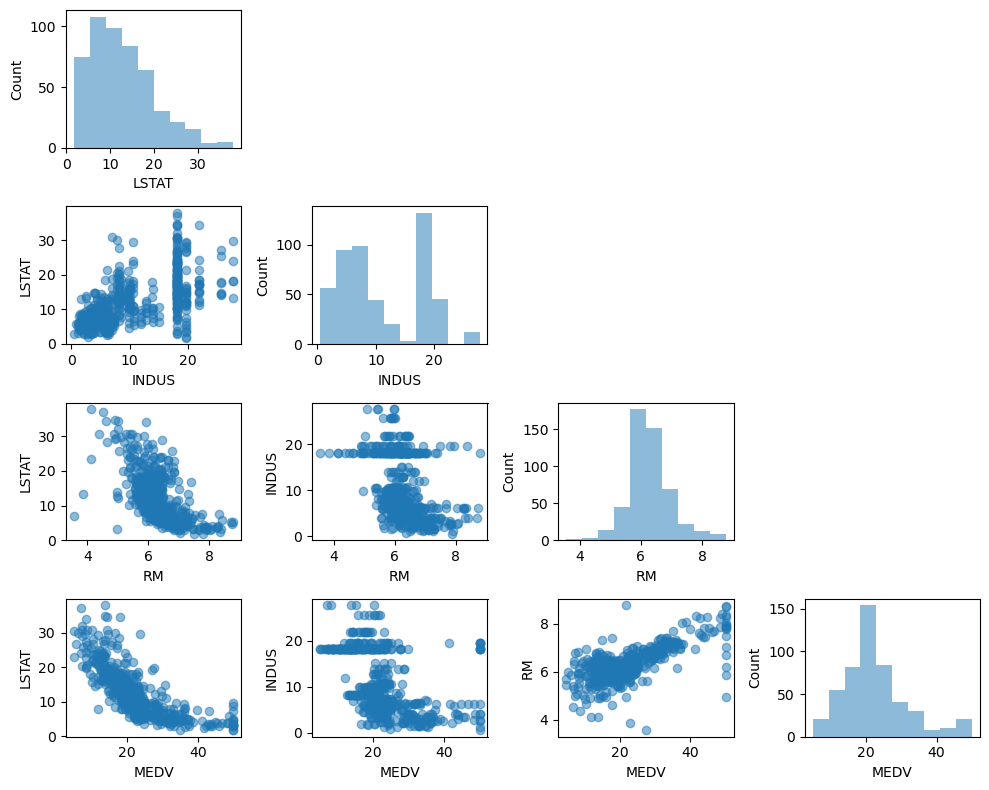

In [15]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

cols = ['LSTAT', 'INDUS', 'RM', 'MEDV']

scatterplotmatrix(df[cols].values, figsize=(10, 8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

相関行列のヒートマップを表示

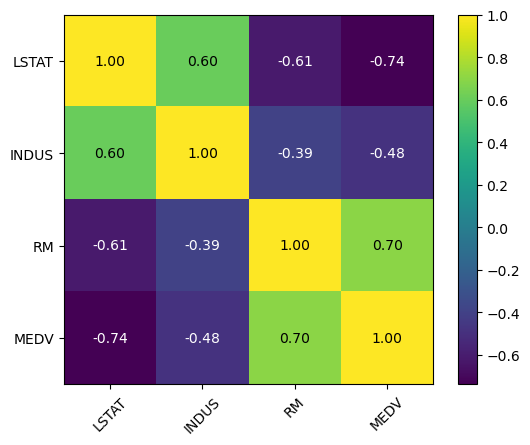

In [16]:
from mlxtend.plotting import heatmap
import numpy as np

cm = np.corrcoef(df[cols].values.T)
heatmap(cm, row_names=cols, column_names=cols)
plt.show()

基本的な線形回帰モデルを実装

ch02/02_adaline と似ている

In [17]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta  # 学習率 : float
        self.n_iter = n_iter  # 訓練回数 : int
        self.w_ = None  # 重み
        self.cost_ = None  # コスト関数

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

実装した線形回帰モデルの動作確認

住宅の平均価格を を 平均部屋数から予測してみる

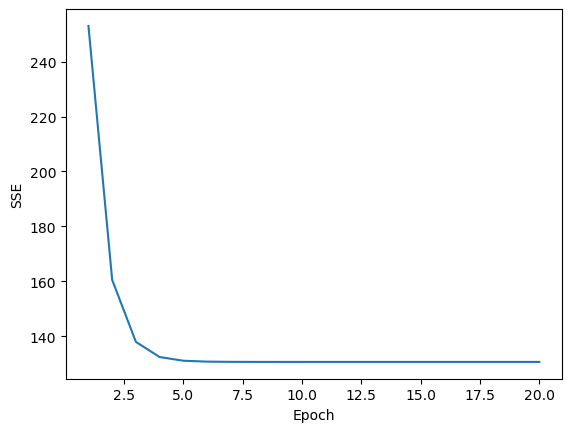

In [18]:
X = df[['RM']].values
y = df['MEDV'].values

from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
sc_y = StandardScaler()
X_std = sc_X.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD()
lr.fit(X_std, y_std)

収束したかどうか確認

In [ ]:
plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

適合状態を可視化

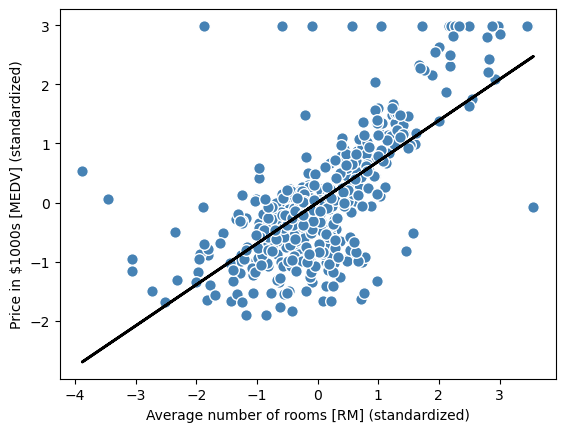

In [19]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolors='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None


lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

価格を元の尺度に戻す

In [20]:
num_rooms_std = sc_X.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print('Price in $1000s: %.3f' % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


変数を標準化すると、切片の重みはゼロになる

In [21]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


scikit-learn で推定

In [22]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)

print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


適合状態を可視化

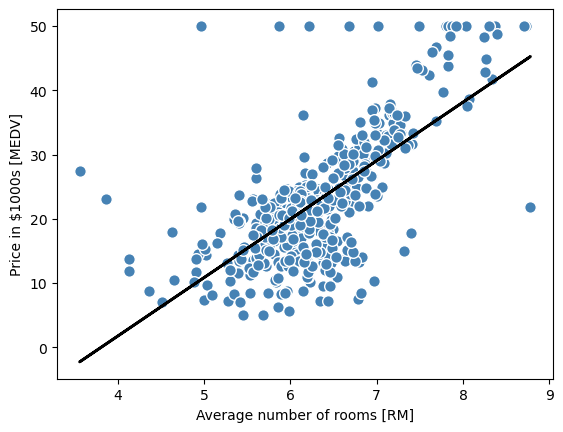

In [23]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

Random Sample Consensus を使ったロバスト回帰で外れ値を推定

In [24]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=0, residual_threshold=5.0)

外れ値を可視化

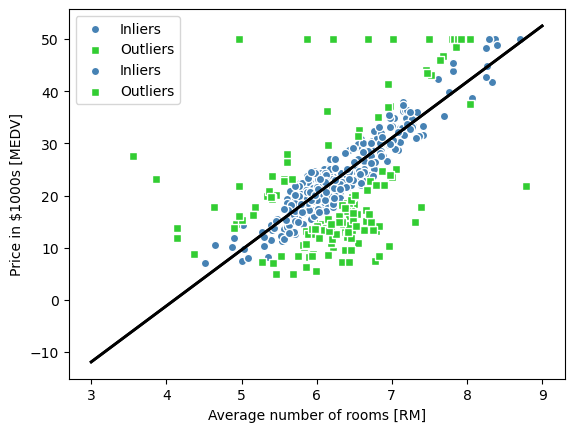

In [26]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

RANSACを使って適合させた結果の係数を出力

In [27]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089
